In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
from pycbc.filter import make_frequency_series
from calcwf import *
from interpolating_match import *
from simple_pe_funcs import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
with open(os.path.join('grid_data', 'dataslot_29', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
grid_data = find_min_max(grid_data, extra_keys=['h1_h0', 'h-1_h0', 'h2_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pca', 'h1_h-1_h0_pcn', 'h1_h-1_h2_h0_pcn'])

In [4]:
grid_data.keys()

dict_keys([5.109216918045607, 8.311202280819249, 11.737898138164017, 15.342013196939702, 19.09412877604935, 22.973967099940698, 26.96660856486353, 31.060565479858784, 35.24669064333487, 39.51750973664827, 43.86678863029888, 48.28923991500753, 52.780316430915754, 57.33606154625207])

Text(0, 0.5, 'rho_x/rho_0')

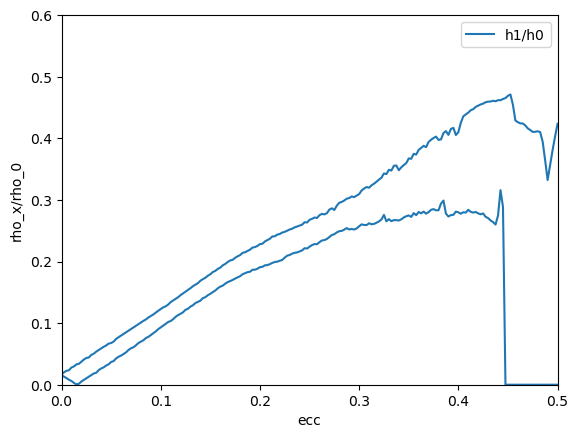

In [5]:
chirp = 48.28923991500753
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_max'], c='C0', label='h1/h0')
plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h0_min'], c='C0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_max'], c='C1', label='h-1/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h-1_h0_min'], c='C1')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h2_h0_max'], c='C2', label='h2/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h2_h0_min'], c='C2')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_max'], c='C3', label='(h1,h-1)/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_min'], c='C3')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_max'], c='C4', label='(h1,h-1)pca/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pca_min'], c='C4')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_max'], c='C5', label='(h1,h-1)pcn/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h0_pcn_min'], c='C5')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h2_h0_pcn_max'], c='C6', label='(h1,h-1,h2)pcn/h0')
# plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp]['h1_h-1_h2_h0_pcn_min'], c='C6')
plt.legend()
plt.xlim(0, np.min([0.5, grid_data[chirp]['fid_e']*4]))
plt.ylim(0, 0.6)
plt.xlabel('ecc')
plt.ylabel('rho_x/rho_0')

# Phase consistency

We expect that the difference between the phase of the match with h1 and h0 should be the same as the difference between the phase of the match with h0 and h-1, as they both give estimates of the initial mean anomaly. We can test this here by looking at the discrepancy for every point in the grid.

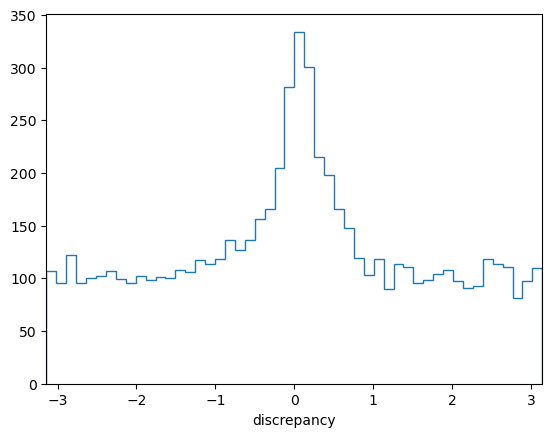

(0.0, 0.26666666666666666)

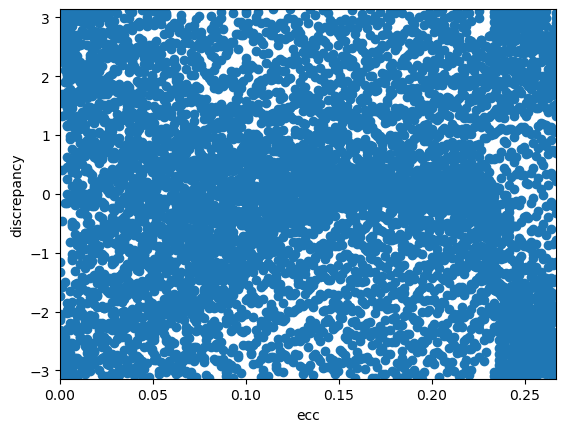

In [11]:
chirp = 11.737898138164017

# Calculating phase differences
h0_phase = grid_data[chirp]['h0_phase']
h1_phase = grid_data[chirp]['h1_phase']
hn1_phase = grid_data[chirp]['h-1_phase']
diff_0 = h1_phase - h0_phase
diff_1 = h0_phase - hn1_phase

# Calculating discrepancies and restricting to between -pi and pi
consistency = diff_1 - diff_0
consistency = (consistency+np.pi)%(2*np.pi)-np.pi

# Plot histogram
plt.hist(consistency.flatten(), bins=50, histtype='step')
plt.xlabel('discrepancy')
plt.xlim(-np.pi, np.pi)
plt.show()

# Plot scatter plot as function of eccentricity along degeneracy line
for i, cons in enumerate(consistency):
    plt.scatter(np.full(len(cons), grid_data[chirp]['e_vals'][i]), cons, c='C0')
plt.ylabel('discrepancy')
plt.xlabel('ecc')
plt.ylim(-np.pi, np.pi)
plt.xlim(0, grid_data[chirp]['e_vals'][-1])

We can see that the discrepancy distribution is indeed centred around zero, supporting our theory that these phase differences should be the same. The discrepancies tend to get bigger at very low eccentricities, likely due to the non/minimal detection of higher harmonics, as well as at high eccentricities, likely due to the similarities to harmonics built at the fiducial eccentricity degrading.

## Equation derivation

We want to maximise the likelihood given by

$$
\log{\Lambda} = (s|h) - \frac{1}{2} (h|h),
$$

where we are using the convention here that (a|b) is the real part of the inner product.

$h$ is the trial waveform given by

$$
h = \sum_k A_k e^{i\phi_k} h_k,
$$

and $s$ is the data given by

$$
s = h^\prime + n,
$$

where $h^\prime$ is the true signal in the data, and $n$ is the noise.

Assuming the noise to be stationary and Gaussian, $(n|h) = 0$ and so we can rewrite the likelihood as 

$$
\log{\Lambda}= (h^\prime|h) - \frac{1}{2} (h|h).
$$

We can now use the orthonormality of $h_k$, where $(h_j|h_k) = \delta_{jk}$ to write this as

$$
\log{\Lambda}= \sum_k A_k^\prime A_k \cos(\phi_k - \phi_k^\prime) - \frac{1}{2} A_k^2.
$$

We will now enforce phase consistency by parameterising $\phi_k$ as 

$$
\phi_k = \alpha + k\beta
$$

in order to find

$$
\log{\Lambda}= \sum_k A_k^\prime A_k \cos(\alpha + k\beta - \phi_k^\prime) - \frac{1}{2} A_k^2.
$$

We can maximise over this numerically using initial guesses of $A_k = A_k^\prime$, $\alpha = \phi_0^\prime$, and $\beta = \phi_1^\prime - \phi_0^\prime$.

The fraction we are then looking for is

$$
\frac{\sqrt{\sum_kA_k^2}}{A_0}.
$$

# Effect of orthogonalisation

We know that the best model for an eccentric waveform using two harmonics is

$$
h = A h_0 + B h_1.
$$

Instead however we build $h_0$ and $h_1^\perp$, where the latter waveform has been orthogonalised using Grant-Schmidt orthogonalisation to remove the overlap between $h_0$ and $h_1$.

$$
h_1^\perp = h_1 - \frac{(h_1| h_0)}{(h_0|h_0)} h_0 \equiv h_1 - \mathcal{O} h_0,
$$

with

$$
(h_1^\perp|h_1^\perp) = (h_1 - \mathcal{O} h_0|h_1 - \mathcal{O} h_0) = (h_1|h_1) + |\mathcal{O}|^2(h_0|h_0) - \mathcal{O}(h_0|h_1) - \mathcal{O}^*(h_1|h_0) = 1 - |\mathcal{O}|^2.
$$

Putting this into our model we see that 

$$
h = \left(A+\mathcal{O}B\right)h_0 + Bh_1^\perp,
$$

such that the SNRs we measure are actually

$$
\rho_0 = (h_0|h) = \left(A+\mathcal{O}B\right)^* (h_0|h_0) = \left(A+\mathcal{O}B\right)^*,
$$

and

$$
\rho_1 = (h_1^\perp|h) = B^* (h_1^\perp|h_1^\perp) = B^*\left(1 - |\mathcal{O}|^2\right).
$$

We can easily calculate $\mathcal{O}$ and so can find $A$ and $B$ with

$$
B = \frac{\rho_1^*}{1 - |\mathcal{O}|^2},
$$

$$
A = \rho_0^* - \mathcal{O}B.
$$

In [2]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
sample_rate = 4096

# Complex coefficients
A = 4+3j
B = -0.5+2j

# Create waveforms
_, h0, h1, _, _ = get_h([1,1], f_low, e, M, q, sample_rate, GS_normalisation=False)
h0_f = h0.real().to_frequencyseries()
h1_f = h1.real().to_frequencyseries()

# Normalise wfs and create orthogonalised h1
psd = gen_psd(h0, f_low)
h0 = h0 / sigma(h0_f, psd, low_frequency_cutoff=f_low, high_frequency_cutoff=psd.sample_frequencies[-1])
h1 = h1 / sigma(h1_f, psd, low_frequency_cutoff=f_low, high_frequency_cutoff=psd.sample_frequencies[-1])
_, h1_perp = GS_orthogonalise(f_low, [h0, h1])
h1_perp_f = h1_perp.real().to_frequencyseries()

# Create total waveform
h = A*h0 + B*h1
h_f = h.real().to_frequencyseries()

# Perform match filter
mode_SNRs, _ = calculate_mode_snr(h_f, psd, {'h0': h0_f, 'h1_perp': h1_perp_f}, h0.sample_times[0], h0.sample_times[-1], f_low, ['h0', 'h1_perp'], dominant_mode='h0')
z = {'H1': mode_SNRs}
rss_snr, _ = network_mode_snr(z, ['H1'], z['H1'].keys(), dominant_mode='h0')
rho_0 = z['H1']['h0']
rho_1 = z['H1']['h1_perp']

# Compute overlap of h0 and h1
O = overlap_cplx(h1.real(), h0.real(), psd=psd, low_frequency_cutoff=f_low, normalized=False)
print(np.abs(O))

0.009413882629242443


In [3]:
# Extract coefficients A and B
B_est = np.conj(rho_1)/(1-np.abs(O)**2)
A_est = np.conj(rho_0) - O*np.conj(rho_1)/(1-np.abs(O)**2)
print(np.conj(rho_0), A_est, A)
print(np.conj(rho_1), B_est, B)

(4.0019815958109675+2.9805617955474144j) (3.9995334003735774+2.9997771689555326j) (4+3j)
(-0.49648135372715413+1.9966922470279298j) (-0.49652535639319484+1.9968692119460933j) (-0.5+2j)


Doesn't seem to be a very big effect for $n=2$ as the overlap is very low.

Now let's try generalise this to $n$ harmonics.

The total waveform is modelled as 

$$
h = \sum_{k=0}^{n-1} A_k h_k,
$$

and we build orthogonal waveforms using

$$
h_k^\perp = h_k - \sum_{j=0}^{k-1}  (h_k|h_j) h_j = h_k - \sum_{j=0}^{k-1} \mathcal{O}_{kj} h_j.
$$

Here I am labelling h0, h1, hn1, h2 etc. as h0, h1, h2, h3 etc. for simplicity of notation, and we have $(h_k|h_k) = 1$ for all $k$.

We compute the overlap of these perpendicular waveforms with themselves as 

$$
(h_k^\perp|h_k^\perp) = (h_k - \sum_{j=0}^{k-1} \mathcal{O}_{kj} h_j|h_k - \sum_{j=0}^{k-1} \mathcal{O}_{kj} h_j) = (h_k|h_k) - \sum_{j=0}^{k-1} \mathcal{O}_{kj}(h_j|h_k)  - \sum_{j=0}^{k-1} \mathcal{O}_{kj}^*(h_k|h_j) + \sum_{j=0}^{k-1} \sum_{i=0}^{k-1} \mathcal{O}_{kj} \mathcal{O}_{ki}^* (h_j|h_i),
$$

$$
(h_k^\perp|h_k^\perp) = 1 - 2\sum_{j=0}^{k-1}|\mathcal{O}_{kj}|^2 + \sum_{j=0}^{k-1}|\mathcal{O}_{kj}|^2 + \sum_{j=0}^{k-1} \sum_{\substack{i=0 \\ i\neq j}}^{k-1} \mathcal{O}_{kj} \mathcal{O}_{ik} \mathcal{O}_{ji},
$$

$$
(h_k^\perp|h_k^\perp) = 1 - \sum_{j=0}^{k-1}|\mathcal{O}_{kj}|^2 + 2\Re \sum_{j=1}^{k-1} \sum_{i=0}^{j-1} \mathcal{O}_{kj} \mathcal{O}_{ik} \mathcal{O}_{ji}.
$$

WIP:

$$
h = \sum_{k=0}^{n-1} A_k h_k^\perp + \sum_{k=0}^{n-1} h_k^\perp \sum_{j=1}^{n-k-1} \sum_{\left(n>m_j>\ldots>m_1>k\right)} A_{m_j} \prod_{i=1}^{j} \mathcal{O}_{m_i m_{i-1}}, 
$$

Our model now becomes

$$
h = \sum_{k=0}^{n-1} A_k h_k^\perp + \sum_{k=1}^{n-1} \sum_{j=0}^{k-1} A_k \mathcal{O}_{kj} h_j^\perp + \sum_{k=2}^{n-1} \sum_{j=1}^{k-1} \sum_{i=0}^{j-1} A_k \mathcal{O}_{kj}  \mathcal{O}_{ji} h_i^\perp + \ldots,
$$

$$
h = \sum_{k=0}^{n-1} A_k h_k^\perp + \sum_{k=0}^{n-1} h_k^\perp \sum_{j=1}^{n-k-1} \sum_{\left(n>m_j>\ldots>m_1>k\right)} A_{m_j} \prod_{i=1}^{j} \mathcal{O}_{m_i m_{i-1}}, 
$$

with $m_0 = k$ and 

$$ A^\prime_{m_i}=   \left\{
\begin{array}{ll}
      A_{m_i}, & i=j \\
      1, & i\neq j \\
\end{array} 
\right.  $$

We will write this as 

$$
h = \sum_{k=0}^{n-1} \alpha_k h_k^\perp,
$$

with

$$
\alpha_k \equiv A_k + \sum_{k=0}^{n-1} h_k^\perp \sum_{j=1}^{n-k-1} \sum_{\left(n>m_j>\ldots>m_1>k\right)} A_{m_j} \prod_{i=1}^{j} \mathcal{O}_{m_i m_{i-1}}.
$$

The SNR can then be computed as

$$
\rho_k = (h_k^\perp|h) = \alpha_k^* (h_k^\perp|h_k^\perp),
$$

such that

$$
\alpha_k = \frac{\rho_k^*}{(h_k^\perp|h_k^\perp)}.
$$

We then end up with

$$
A_{k} = \frac{\rho_k^*}{(h_k^\perp|h_k^\perp)} - \sum_{j=1}^{n-k-1} \sum_{\left(n>m_j>\ldots>m_1>k\right)} A_{m_j} \prod_{i=1}^{j} \mathcal{O}_{m_i m_{i-1}}.
$$

As $m_i$ must always be higher than $k$, if we should compute each $A_k$ in turn, starting at $k=n-1$ and descending. This way, we will always have already calculated all the $A_{m_i}$ required in the second term above to calculate $A_k$.

In [2]:
# Parameters
n = 4
f_low = 10
e = 0.2
M = 60
q = 2
sample_rate = 4096

# Complex coefficients
As = [4+3j, -0.5+2j, 1-0.5j, 0.5+0.5j]

# Create waveforms and normalise
all_wfs = list(get_h([1]*n, f_low, e, M, q, sample_rate, GS_normalisation=False))
h_wfs = all_wfs[1:n+1]
psd = gen_psd(h_wfs[0], f_low)
h_wfs_f = []
for i in range(n):
    h_wfs_f.append(h_wfs[i].real().to_frequencyseries())
    h_wfs[i] /= sigma(h_wfs_f[i], psd, low_frequency_cutoff=f_low, high_frequency_cutoff=psd.sample_frequencies[-1])
    
# Create total and orthogonal waveforms
h = h_wfs[0]*As[0]
for i in range(n-1):
    h += h_wfs[i+1]*As[i+1]
h_f = h.real().to_frequencyseries()
h_wfs_perp = GS_orthogonalise(f_low, h_wfs.copy())
h_wfs_perp_f = {}
for i in range(n):
    h_wfs_perp_f[i] = (h_wfs_perp[i].real().to_frequencyseries())

# Perform match filter
mode_SNRs, _ = calculate_mode_snr(h_f, psd, h_wfs_perp_f, h_wfs[0].sample_times[0], h_wfs[0].sample_times[-1], f_low, h_wfs_perp_f.keys(), dominant_mode=0)
z = {'H1': mode_SNRs}
rhos = {}
for key in z['H1'].keys():
    rhos[key] = z['H1'][key]

In [3]:
# Estimate coefficient values
ovlps, ovlps_perp = get_ortho_ovlps(h_wfs, f_low)
est_coeffs = estimate_coeffs(rhos, ovlps, ovlps_perp)

for i in range(4):
    print(np.conj(rhos[i]), est_coeffs[i], As[i])

(4.347564431074242+2.6555593051086235j) (3.986562038336718+3.0169602768174513j) (4+3j)
(-0.5168234513228898+1.946888911398305j) (-0.45461854435043386+1.997027001244468j) (-0.5+2j)
(0.9523074440107099-0.5252959721990631j) (1.0296806353035861-0.5579432775500986j) (1-0.5j)
(0.4996786074141964+0.49336729611129304j) (0.5035306409229706+0.49717067558072603j) (0.5+0.5j)


Now I will calculate the explicit form of these equations for n=4 in order to check the above calculation for general n.

$$
h = A_0 h_0 + A_1 h_1 + A_2 h_2 + A_3 h_3.
$$

$$
h_0^\perp = h_0,
$$

$$
h_1^\perp = h_1 - (h_1| h_0) h_0 = h_1 - \mathcal{O}_{10} h_0,
$$

$$
h_2^\perp = h_2 - (h_2| h_1) h_1 - (h_2| h_0) h_0 = h_2 - \mathcal{O}_{21} h_1 - \mathcal{O}_{20} h_0,
$$

$$
h_3^\perp = h_3 - (h_3| h_2) h_2 - (h_3| h_1) h_1 - (h_3| h_0) h_0 = h_3 - \mathcal{O}_{32} h_2 - \mathcal{O}_{31} h_1 - \mathcal{O}_{30} h_0.
$$

$$
(h_0^\perp|h_0^\perp) = 1,
$$

$$
(h_1^\perp|h_1^\perp) = (h_1 - \mathcal{O}_{10} h_0|h_1 - \mathcal{O}_{10} h_0) = (h_1|h_1) + |\mathcal{O}_{10}|^2(h_0|h_0) - \mathcal{O}_{10}(h_0|h_1) - \mathcal{O}_{01}(h_1|h_0) = 1 - |\mathcal{O}_{10}|^2,
$$

$$
(h_2^\perp|h_2^\perp) = (h_2 - \mathcal{O}_{21} h_1 - \mathcal{O}_{20} h_0|h_2 - \mathcal{O}_{21} h_1 - \mathcal{O}_{20} h_0) = (h_2|h_2) + |\mathcal{O}_{21}|^2(h_1|h_1) + |\mathcal{O}_{20}|^2(h_0|h_0) - \mathcal{O}_{21}(h_1|h_2) - \mathcal{O}_{12}(h_2|h_1) - \mathcal{O}_{20}(h_0|h_2) - \mathcal{O}_{02}(h_2|h_0) + \mathcal{O}_{20} \mathcal{O}_{12} (h_0|h_1) + \mathcal{O}_{02} \mathcal{O}_{21} (h_1|h_0),
$$

$$
(h_2^\perp|h_2^\perp) = 1 - |\mathcal{O}_{21}|^2 - |\mathcal{O}_{20}|^2 + \mathcal{O}_{20} \mathcal{O}_{12} \mathcal{O}_{01} + \mathcal{O}_{02} \mathcal{O}_{21} \mathcal{O}_{10},
$$

$$
(h_3^\perp|h_3^\perp) = (h_3 - \mathcal{O}_{32} h_2 - \mathcal{O}_{31} h_1 - \mathcal{O}_{30} h_0|h_3 - \mathcal{O}_{32} h_2 - \mathcal{O}_{31} h_1 - \mathcal{O}_{30} h_0),
$$

$$
(h_3^\perp|h_3^\perp) = (h_3|h_3) + |\mathcal{O}_{32}|^2(h_2|h_2) + |\mathcal{O}_{31}|^2(h_1|h_1) + |\mathcal{O}_{30}|^2(h_0|h_0) - \mathcal{O}_{32}(h_2|h_3) - \mathcal{O}_{23}(h_3|h_2) - \mathcal{O}_{31}(h_1|h_3) - \mathcal{O}_{13}(h_3|h_1) - \mathcal{O}_{30}(h_0|h_3) - \mathcal{O}_{03}(h_3|h_0) + \mathcal{O}_{31} \mathcal{O}_{23} (h_1|h_2) + \mathcal{O}_{13} \mathcal{O}_{32} (h_2|h_1) + \mathcal{O}_{30} \mathcal{O}_{23} (h_0|h_2) + \mathcal{O}_{03} \mathcal{O}_{32} (h_2|h_0) + \mathcal{O}_{30} \mathcal{O}_{13} (h_0|h_1) + \mathcal{O}_{03} \mathcal{O}_{31} (h_1|h_0),
$$

$$
(h_3^\perp|h_3^\perp) = 1 - |\mathcal{O}_{32}|^2 - |\mathcal{O}_{31}|^2 - |\mathcal{O}_{30}|^2  + \mathcal{O}_{31} \mathcal{O}_{23} \mathcal{O}_{12} + \mathcal{O}_{13} \mathcal{O}_{32} \mathcal{O}_{21} + \mathcal{O}_{30} \mathcal{O}_{23} \mathcal{O}_{02} + \mathcal{O}_{03} \mathcal{O}_{32} \mathcal{O}_{20} + \mathcal{O}_{30} \mathcal{O}_{13} \mathcal{O}_{01} + \mathcal{O}_{03} \mathcal{O}_{31} \mathcal{O}_{10}.
$$

$$
h = A_0 h_0^\perp + A_1 \left( h_1^\perp + \mathcal{O}_{10}h_0^\perp\right) + A_2 \left( h_2^\perp + \mathcal{O}_{21} h_1 + \mathcal{O}_{20} h_0^\perp\right) + A_3 \left( h_3^\perp + \mathcal{O}_{32} h_2 + \mathcal{O}_{31} h_1 + \mathcal{O}_{30} h_0^\perp\right),
$$

$$
h = A_0 h_0^\perp + A_1 \left( h_1^\perp + \mathcal{O}_{10}h_0^\perp\right) + A_2 \left( h_2^\perp + \mathcal{O}_{21} \left[h_1^\perp + \mathcal{O}_{10}h_0^\perp\right] + \mathcal{O}_{20} h_0^\perp\right) + A_3 \left( h_3^\perp + \mathcal{O}_{32} \left[h_2^\perp + \mathcal{O}_{21} h_1 + \mathcal{O}_{20} h_0^\perp\right] + \mathcal{O}_{31} \left[h_1^\perp + \mathcal{O}_{10}h_0^\perp\right] + \mathcal{O}_{30} h_0^\perp\right),
$$

$$
h = A_0 h_0^\perp + A_1 \left( h_1^\perp + \mathcal{O}_{10}h_0^\perp\right) + A_2 \left( h_2^\perp + \mathcal{O}_{21} \left[h_1^\perp + \mathcal{O}_{10}h_0^\perp\right] + \mathcal{O}_{20} h_0^\perp\right) + A_3 \left( h_3^\perp + \mathcal{O}_{32} \left[h_2^\perp + \mathcal{O}_{21} \left\{h_1^\perp + \mathcal{O}_{10}h_0^\perp\right\} + \mathcal{O}_{20} h_0^\perp\right] + \mathcal{O}_{31} \left[h_1^\perp + \mathcal{O}_{10}h_0^\perp\right] + \mathcal{O}_{30} h_0^\perp\right),
$$

$$
h = h_0^\perp \left(A_0 + A_1 \mathcal{O}_{10} + A_2 \mathcal{O}_{21}\mathcal{O}_{10} + A_2 \mathcal{O}_{20} + A_3 \mathcal{O}_{32}\mathcal{O}_{21}\mathcal{O}_{10} + A_3 \mathcal{O}_{32}\mathcal{O}_{20} + A_3 \mathcal{O}_{31}\mathcal{O}_{10} + A_3 \mathcal{O}_{30}\right) + h_1^\perp \left(A_1 + A_2 \mathcal{O}_{21} + A_3 \mathcal{O}_{32}\mathcal{O}_{21} + A_3 \mathcal{O}_{31}\right) + h_2^\perp \left(A_2 + A_3 \mathcal{O}_{32}\right) + A_3 h_3^\perp,
$$

$$
h \equiv \alpha_0 h_0^\perp + \alpha_1 h_1^\perp + \alpha_2 h_2^\perp + \alpha_3 h_3^\perp.
$$

$$
\alpha_k = \frac{\rho_k^*}{(h_k^\perp|h_k^\perp)}.
$$

$$
A_3 = \frac{\rho_3^*}{(h_3^\perp|h_3^\perp)},
$$

$$
A_2 = \frac{\rho_2^*}{(h_2^\perp|h_2^\perp)} - A_3 \mathcal{O}_{32},
$$

$$
A_1 = \frac{\rho_1^*}{(h_1^\perp|h_1^\perp)} - A_2 \mathcal{O}_{21} - A_3 \mathcal{O}_{32}\mathcal{O}_{21} - A_3 \mathcal{O}_{31},
$$

$$
A_0 = \frac{\rho_0^*}{(h_0^\perp|h_0^\perp)} - A_1 \mathcal{O}_{10} - A_2 \mathcal{O}_{21}\mathcal{O}_{10} - A_2 \mathcal{O}_{20} - A_3 \mathcal{O}_{32}\mathcal{O}_{21}\mathcal{O}_{10} - A_3 \mathcal{O}_{32}\mathcal{O}_{20} - A_3 \mathcal{O}_{31}\mathcal{O}_{10} - A_3 \mathcal{O}_{30}.
$$

In [4]:
# Check perpendicular overlaps
ovlps, ovlps_perp_gen = get_ortho_ovlps(h_wfs, f_low)

# Explicit calculation
ovlps_perp = {}
ovlps_perp[0] = 1
ovlps_perp[1] = 1 - np.abs(ovlps[1][0])**2
ovlps_perp[2] = 1 - np.abs(ovlps[2][1])**2 - np.abs(ovlps[2][0])**2 + np.real(ovlps[2][0]*np.conj(ovlps[2][1])*np.conj(ovlps[1][0]) + np.conj(ovlps[2][0])*ovlps[2][1]*ovlps[1][0])
ovlps_perp[3] = 1 - np.abs(ovlps[3][2])**2 - np.abs(ovlps[3][1])**2 - np.abs(ovlps[3][0])**2 \
                + np.real(ovlps[3][1]*np.conj(ovlps[3][2])*np.conj(ovlps[2][1]) + np.conj(ovlps[3][1])*ovlps[3][2]*ovlps[2][1] \
                + ovlps[3][0]*np.conj(ovlps[3][2])*np.conj(ovlps[2][0]) + np.conj(ovlps[3][0])*ovlps[3][2]*ovlps[2][0] \
                + ovlps[3][0]*np.conj(ovlps[3][1])*np.conj(ovlps[1][0]) + np.conj(ovlps[3][0])*ovlps[3][1]*ovlps[1][0])

# Compare
for i in range(4):
    print(ovlps_perp[i], ovlps_perp_gen[i])

1 1
0.986585947318687 0.986585947318687
0.9181478129319808 0.9181478129319808
0.9923499521266205 0.9923499521266205


In [5]:
# Check coefficient estimates
est_coeffs_gen = estimate_coeffs(rhos, ovlps, ovlps_perp)

# Explicit calculation
est_coeffs = {}
est_coeffs[3] = np.conj(rhos[3])/ovlps_perp[3]
est_coeffs[2] = np.conj(rhos[2])/ovlps_perp[2] - est_coeffs[3]*ovlps[3][2]
est_coeffs[1] = np.conj(rhos[1])/ovlps_perp[1] - est_coeffs[2]*ovlps[2][1] - est_coeffs[3]*ovlps[3][2]*ovlps[2][1] - est_coeffs[3]*ovlps[3][1]
est_coeffs[0] = np.conj(rhos[0])/ovlps_perp[0] - est_coeffs[1]*ovlps[1][0] - est_coeffs[2]*ovlps[2][1]*ovlps[1][0] - est_coeffs[2]*ovlps[2][0] \
                - est_coeffs[3]*ovlps[3][2]*ovlps[2][1]*ovlps[1][0] - est_coeffs[3]*ovlps[3][2]*ovlps[2][0] - est_coeffs[3]*ovlps[3][1]*ovlps[1][0] - est_coeffs[3]*ovlps[3][0]

# Compare
for i in range(4):
    print(est_coeffs[i], est_coeffs_gen[i])

(3.986562038336718+3.016960276817451j) (3.9865620383367184+3.0169602768174513j)
(-0.45461854435043386+1.9970270012444682j) (-0.4546185443504339+1.997027001244468j)
(1.029680635303586-0.5579432775500985j) (1.029680635303586-0.5579432775500985j)
(0.5035306409229706+0.49717067558072603j) (0.5035306409229706+0.49717067558072603j)


# Comparing above

In [6]:
with open(os.path.join('grid_data', 'dataslot_30', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)

# Find min and max
chirp = list(grid_data.keys())[0]
keys = list(grid_data[chirp].keys())
for key in keys:
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        grid_data[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data[chirp][key]), axis=1)
        grid_data[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data[chirp][key]), axis=1)

In [7]:
grid_data[chirp]['ovlps_perp']

{0: 1, 1: 0.9987102752212584, 2: 0.9740021970824907, 3: 0.8341163889651404}

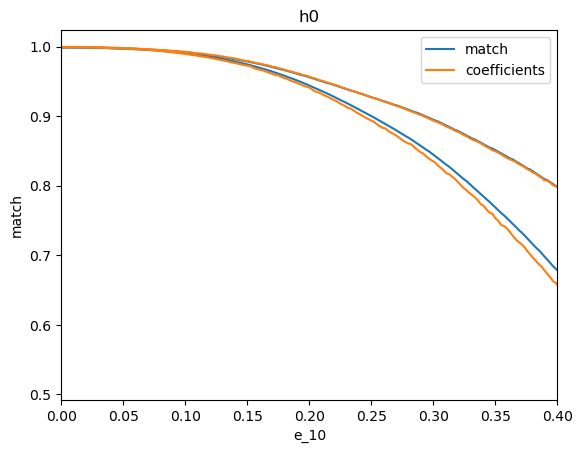

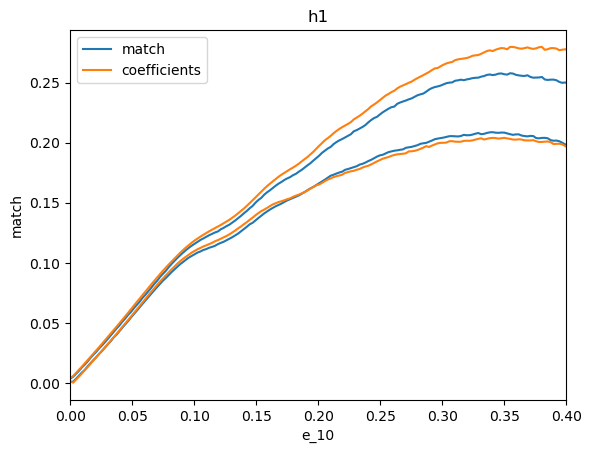

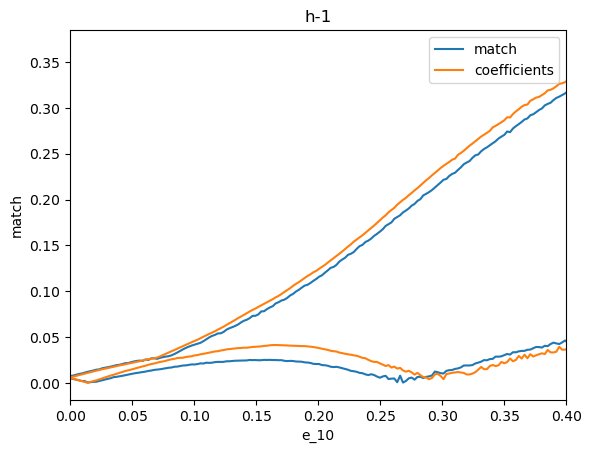

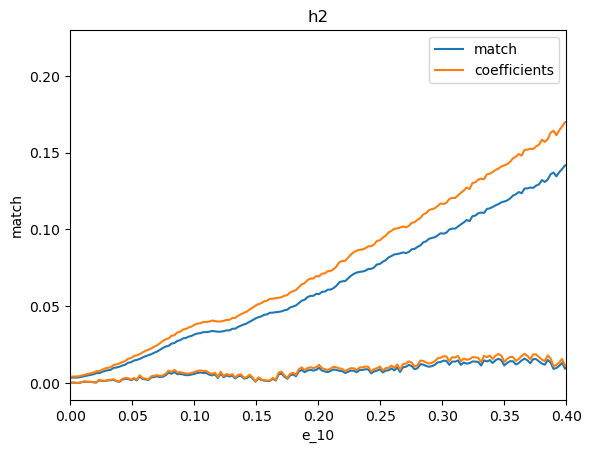

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


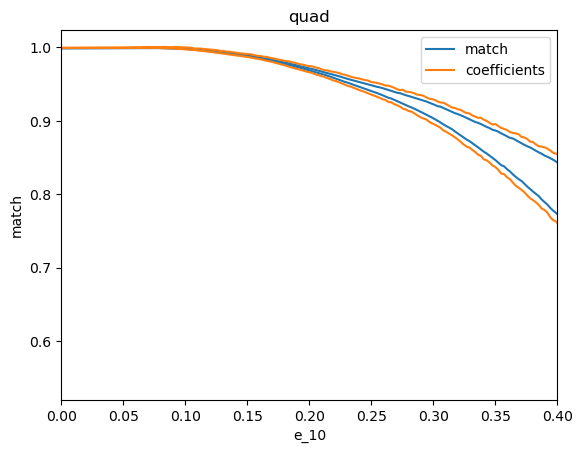

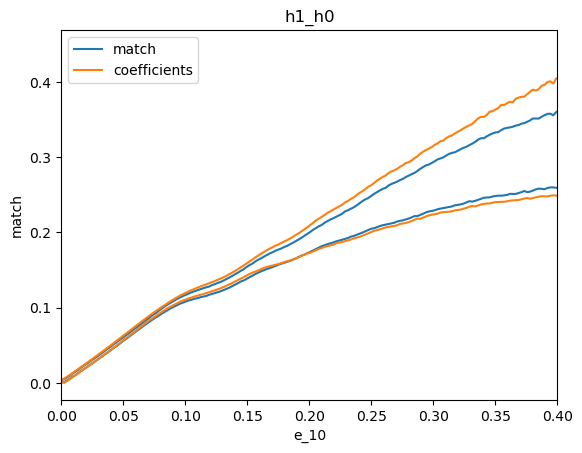

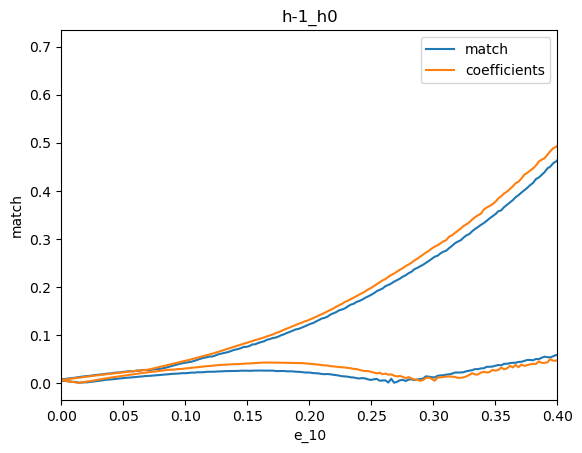

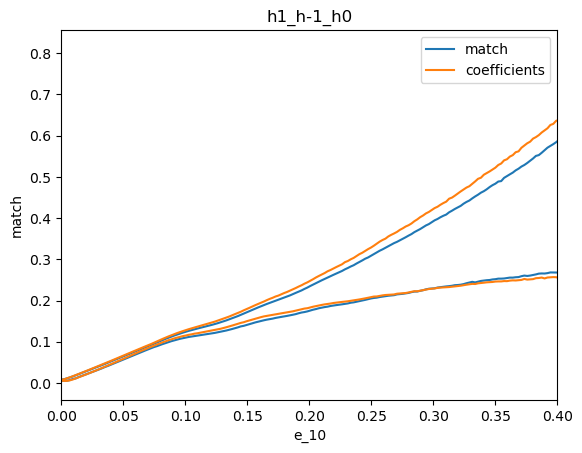

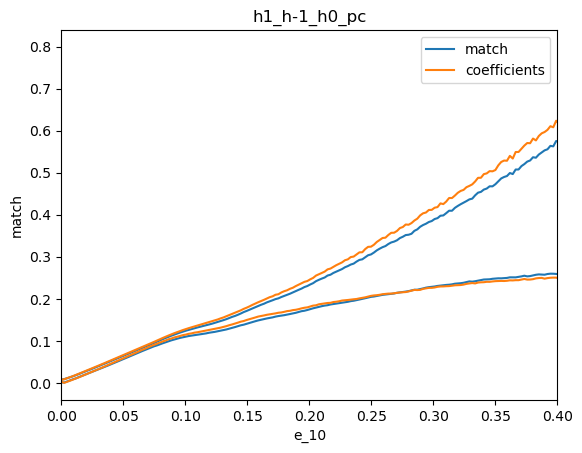

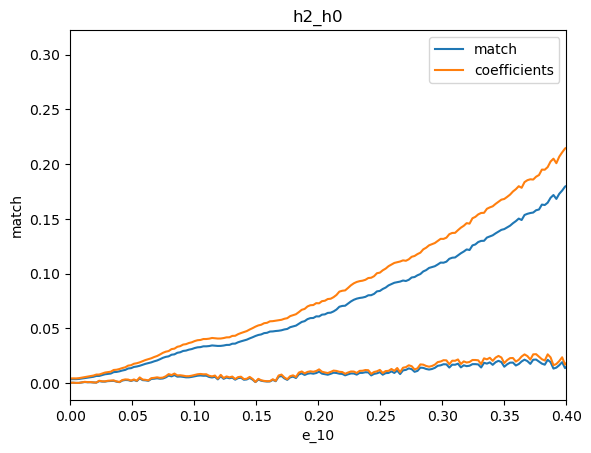

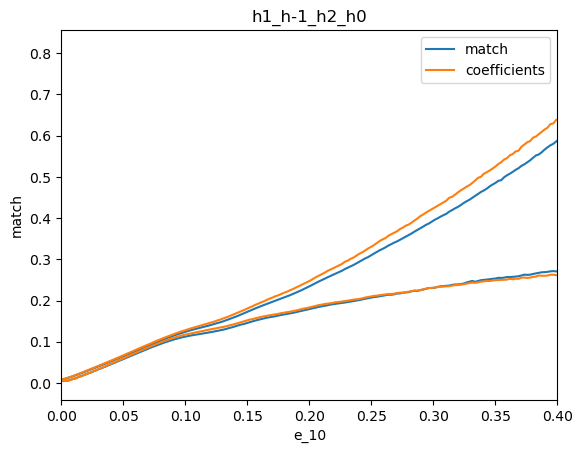

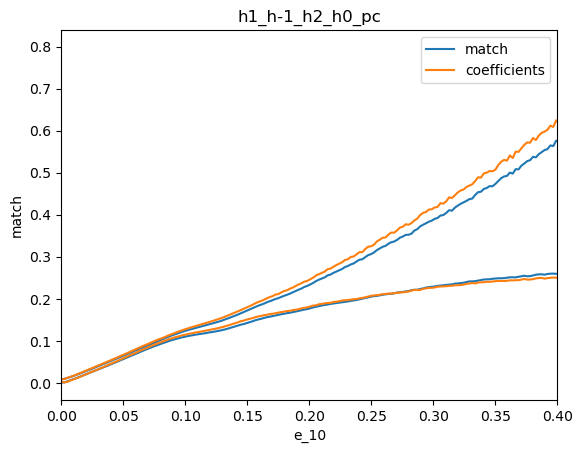

In [8]:
# Make plots
for key in keys:
    if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
        if key[-2:] != '_c':
            plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp][f'{key}_max'], c='C0', label='match')
            plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp][f'{key}_min'], c='C0')
            plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp][f'{key}_c_max'], c='C1', label='coefficients')
            plt.plot(grid_data[chirp]['e_vals'], grid_data[chirp][f'{key}_c_min'], c='C1')

            # Formatting
            plt.title(key)
            plt.xlabel('e_10')
            plt.ylabel('match')
            plt.legend()
            #plt.ylim(0,)
            plt.xlim(0, 0.4)
            plt.show()

In [30]:
grid_data[chirp].keys()

dict_keys(['h0', 'h0_phase', 'h1', 'h1_phase', 'h-1', 'h-1_phase', 'h2', 'h2_phase', 'quad', 'h1_h0', 'h-1_h0', 'h1_h-1_h0', 'h1_h-1_h0_pc', 'h2_h0', 'h1_h-1_h2_h0', 'h1_h-1_h2_h0_pc', 'h0_c', 'h0_phase_c', 'h1_c', 'h1_phase_c', 'h-1_c', 'h-1_phase_c', 'h2_c', 'h2_phase_c', 'quad_c', 'h1_h0_c', 'h-1_h0_c', 'h1_h-1_h0_c', 'h1_h-1_h0_pc_c', 'h2_h0_c', 'h1_h-1_h2_h0_c', 'h1_h-1_h2_h0_pc_c', 'fid_params', 'e_vals', 'ovlps', 'ovlps_perp'])